In [1]:
%load_ext autoreload
%autoreload 2

## Importing & Setting Style

In [2]:
# imports
import os, sys, string, re, itertools, random

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

import pandas as pd
import numpy as np

import nltk

from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

# # updates for nltk helper packages
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

from src import visualizations as vz
from src import functions as fn

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='Blues_r')
pd.options.display.max_rows = 300

## `dir` Check

In [3]:
!pwd

/Users/dsbox/Documents/Flatiron/p_4_project/nlp_sentiment_project/notebooks/exploratory


## Importing Data & Checking Info

In [4]:
path = path = os.path.join(gparent, 'data/raw',\
                           'judge-1377884607_tweet_product_company.csv')
df = pd.read_csv(path, encoding='unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


## Checking Null Tweet

In [6]:
df[df['tweet_text'].isnull()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
6,NaN,NaN,No emotion toward brand or product


## Dropping Null Tweet

In [7]:
df.drop(6, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9092 entries, 0 to 9091
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


## Renaming Columns
The original names are a bit unwieldy.

In [9]:
rename_dict = {'tweet_text': 'tweet', 
               'emotion_in_tweet_is_directed_at': 'brand_product', 
               'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion' }
df.rename(columns=rename_dict, inplace=True)
df.head()

,tweet,brand_product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Checking for Duplicated Tweets

In [10]:
df.shape

(9092, 3)

In [11]:
dupes = df[df['tweet'].duplicated()]

In [12]:
len(dupes)

27

In [13]:
dupes

,tweet,brand_product,emotion
467,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
775,Google to Launch Major New Social Network Call...,NaN,No emotion toward brand or product
2231,Marissa Mayer: Google Will Connect the Digital...,NaN,No emotion toward brand or product
2558,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
3812,Win free ipad 2 from webdoc.com #sxsw RT,iPad,Positive emotion
3813,Win free iPad 2 from webdoc.com #sxsw RT,iPad,Positive emotion
3949,Really enjoying the changes in Gowalla 3.0 for...,Android App,Positive emotion
3961,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
4896,"Oh. My. God. The #SXSW app for iPad is pure, u...",iPad or iPhone App,Positive emotion
5337,RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ...,NaN,No emotion toward brand or product


In [14]:
df.drop_duplicates(subset='tweet',inplace=True)

In [15]:
df.shape

(9065, 3)

## Adding a Hashtag Column

In [16]:
df['hashtags'] = df['tweet'].apply(lambda x: re.findall(r'\B#\w*[a-zA-Z]+\w*', x))

In [17]:
df.head()

,tweet,brand_product,emotion,hashtags
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[#RISE_Austin, #SXSW]"
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,[#SXSW]
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[#iPad, #SXSW]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,[#sxsw]
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,[#SXSW]


## Exploring the Hashtags

In [18]:
hashlists = df['hashtags'].tolist()

In [19]:
hashtags = [hashtag.lower() for h_list in hashlists for hashtag in h_list]

In [20]:
hashtags[:10]

['#rise_austin',
 '#sxsw',
 '#sxsw',
 '#ipad',
 '#sxsw',
 '#sxsw',
 '#sxsw',
 '#speechtherapy',
 '#sxsw',
 '#iear']

In [21]:
len(hashtags)

15779

In [22]:
len(set(hashtags))

1460

In [23]:
hts = pd.DataFrame(hashtags, columns=['hashtags'])

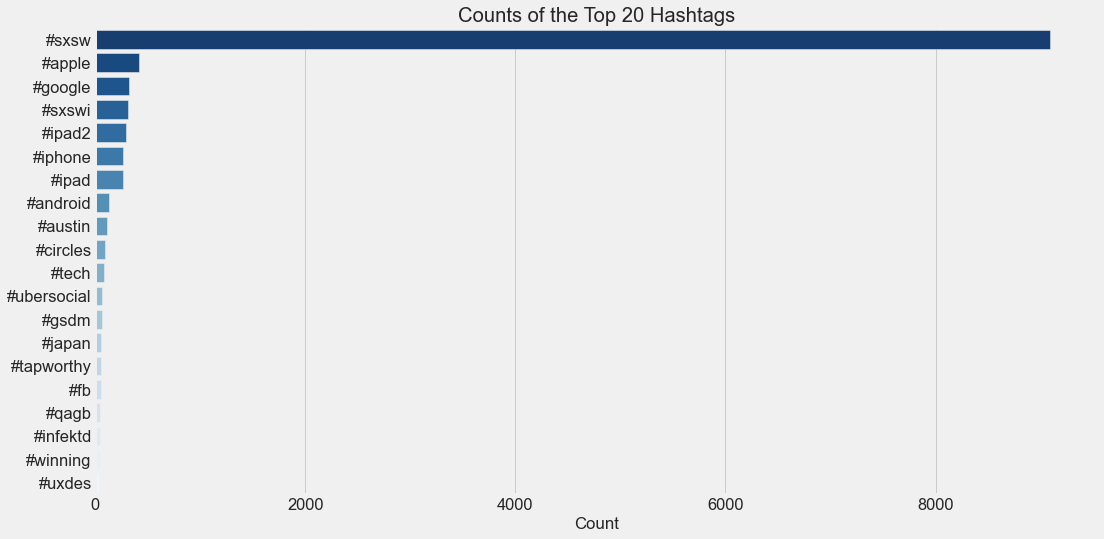

In [24]:
vz.hashtag_c(hts)

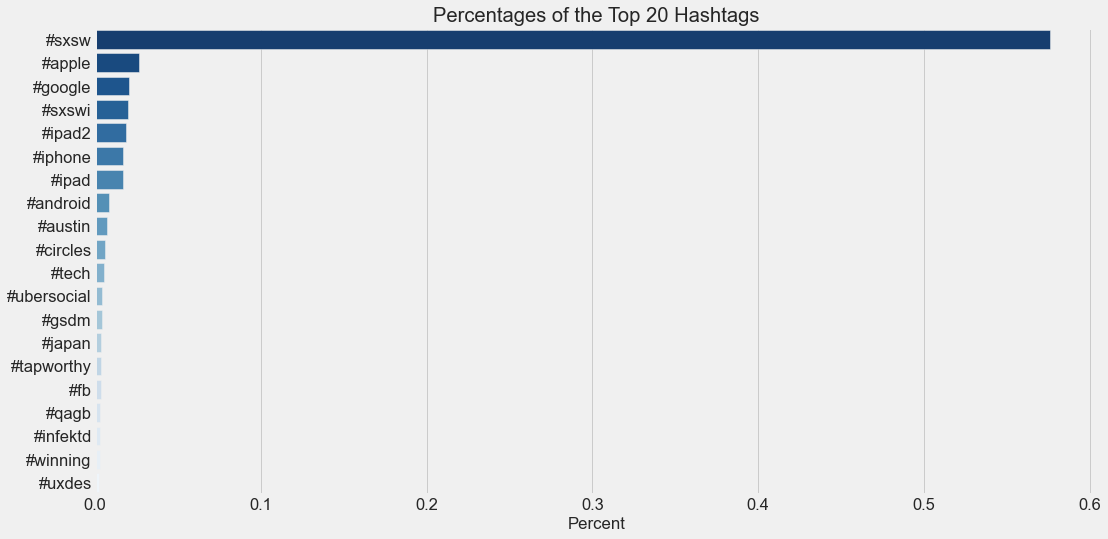

In [25]:
vz.hashtag_p(hts)

## Checking Brand/Product Unique Values

In [26]:
df.brand_product.unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

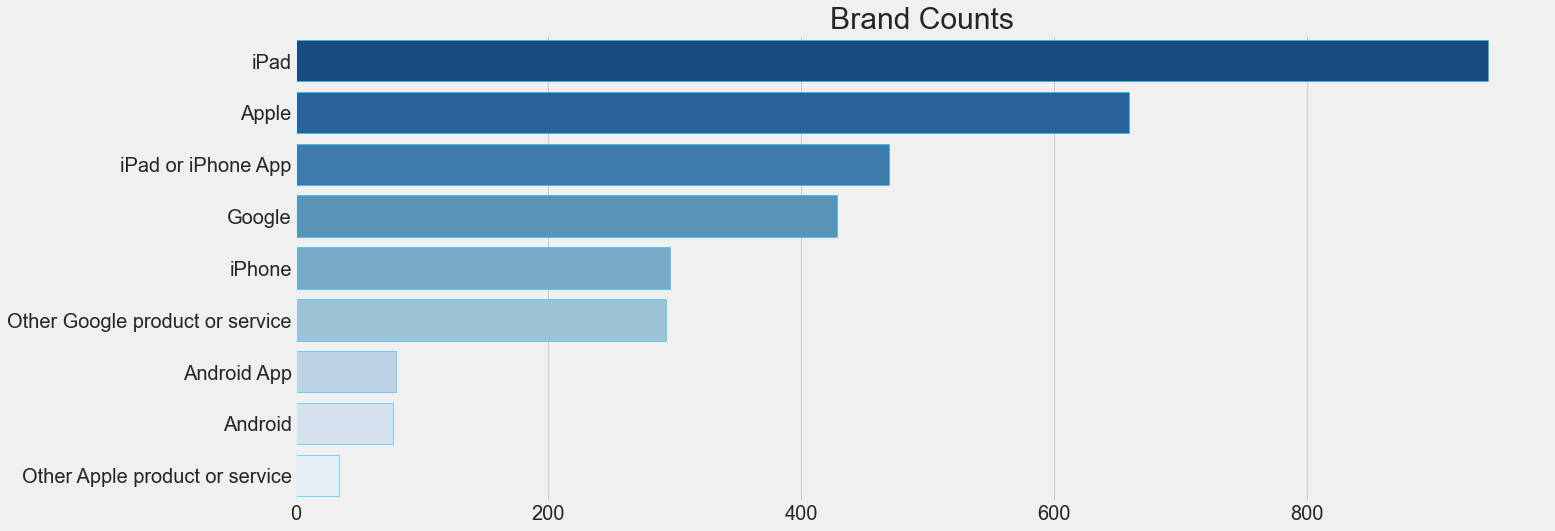

In [27]:
vz.brand_counts(df)

In [28]:
df.brand_product.value_counts()

iPad                               943
Apple                              659
iPad or iPhone App                 469
Google                             428
iPhone                             296
Other Google product or service    293
Android App                         80
Android                             77
Other Apple product or service      35
Name: brand_product, dtype: int64

In [29]:
df.brand_product.isna().sum()

5785

## Checking Emotion Unique Values

In [30]:
df.emotion.unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

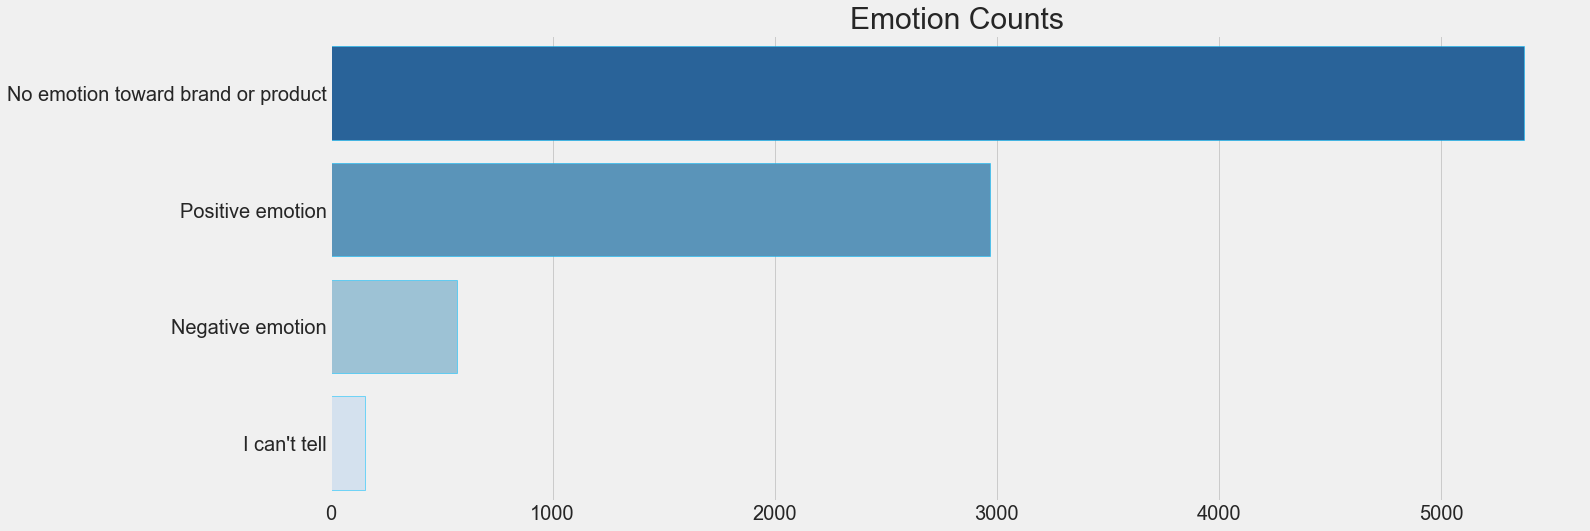

In [31]:
vz.emotion_counts(df)

In [32]:
df.emotion.value_counts()

No emotion toward brand or product    5372
Positive emotion                      2968
Negative emotion                       569
I can't tell                           156
Name: emotion, dtype: int64

## Emotions by Brand

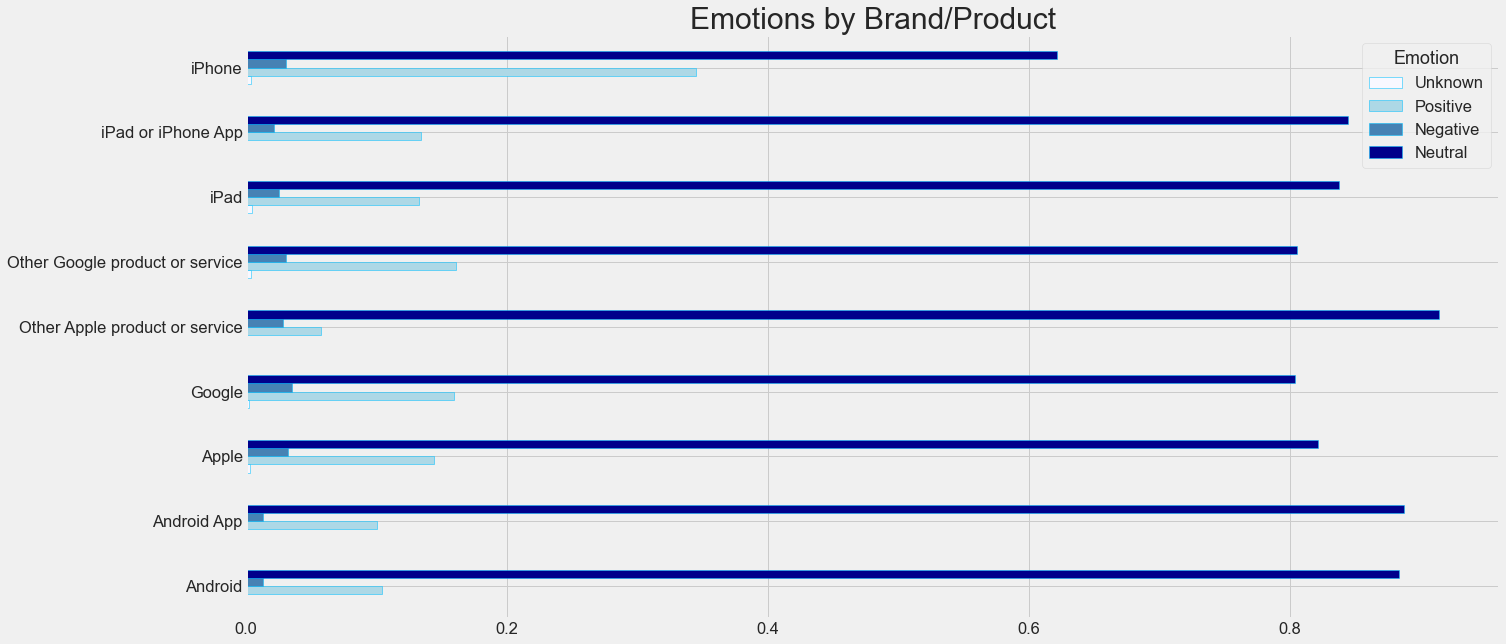

In [33]:
vz.brand_emotions(df)

## Checking Nulls in Product Column

In [34]:
product_nulls = df[df['brand_product'].isnull()]

In [35]:
product_nulls.head()

,tweet,brand_product,emotion,hashtags
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product,"[#SpeechTherapy, #SXSW, #iear, #edchat, #asd]"
15,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product,[#sxsw]
31,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product,"[#SXSW, #GDGTLive]"
32,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product,[#sxsw]
33,Anyone at #SXSW who bought the new iPad want ...,NaN,No emotion toward brand or product,[#SXSW]


In [36]:
product_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5785 entries, 5 to 9091
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet          5785 non-null   object
 1   brand_product  0 non-null      object
 2   emotion        5785 non-null   object
 3   hashtags       5785 non-null   object
dtypes: object(4)
memory usage: 226.0+ KB


In [37]:
product_nulls['emotion'].value_counts()

No emotion toward brand or product    5281
Positive emotion                       306
I can't tell                           147
Negative emotion                        51
Name: emotion, dtype: int64

## Checking Null Brands Emotion Data

In [38]:
null_brand_emotions = df[(df['brand_product'].isna()) &\
                        (df['emotion'] != 'No emotion toward brand or product')]

In [39]:
null_brand_emotions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504 entries, 45 to 9057
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet          504 non-null    object
 1   brand_product  0 non-null      object
 2   emotion        504 non-null    object
 3   hashtags       504 non-null    object
dtypes: object(4)
memory usage: 19.7+ KB


In [40]:
null_brand_emotions.head()

,tweet,brand_product,emotion,hashtags
45,Hand-Held Û÷HoboÛª: Drafthouse launches Û÷H...,NaN,Positive emotion,[#SXSW]
63,Again? RT @mention Line at the Apple store is ...,NaN,Negative emotion,[#sxsw]
67,Boooo! RT @mention Flipboard is developing an ...,NaN,Negative emotion,[#sxsw]
89,Thanks to @mention for publishing the news of ...,NaN,I can't tell,"[#sxswi, #sxsw, #sxswh]"
101,ÛÏ@mention &quot;Apple has opened a pop-up st...,NaN,I can't tell,"[#SXSW, #wow]"


## Null Brand Emotion Counts

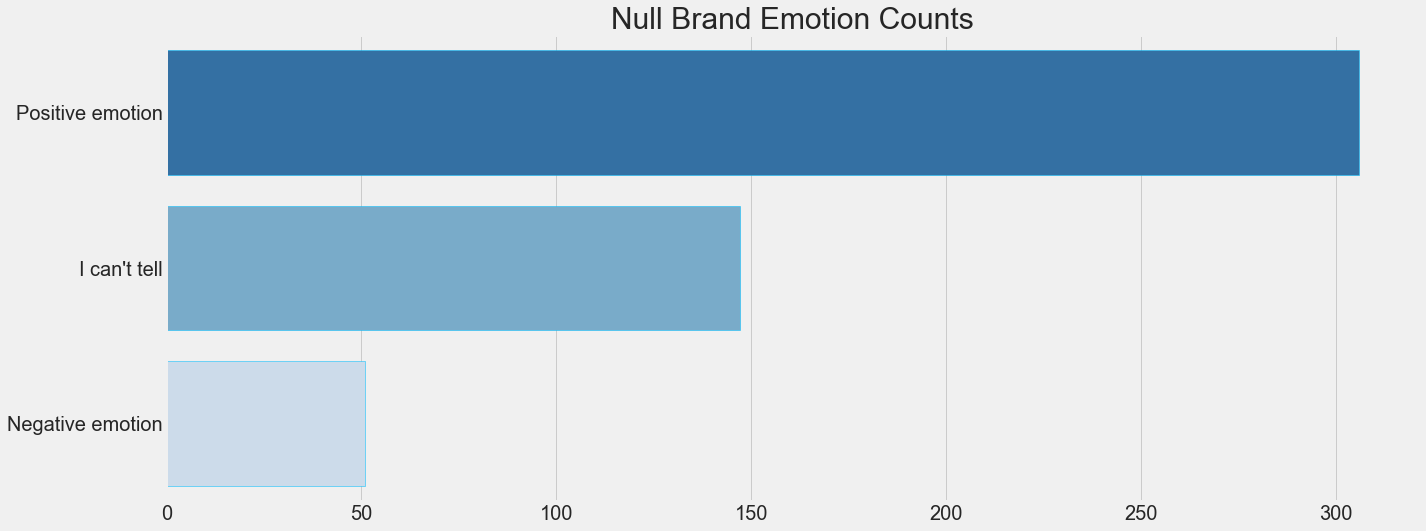

In [41]:
vz.null_brand_emotions(df)

## Examining Some Null Brand Tweets

In [42]:
print(null_brand_emotions.tweet[45])

Hand-Held Û÷HoboÛª: Drafthouse launches Û÷Hobo With a ShotgunÛª iPhone app #SXSW {link}


In [43]:
print(null_brand_emotions.tweet[63])

Again? RT @mention Line at the Apple store is insane.. #sxsw


In [44]:
print(null_brand_emotions.tweet[67])

Boooo! RT @mention Flipboard is developing an iPhone version, not Android, says @mention #sxsw


## Filtering for Binary Emotion Data
The intial model will be trained to classify positive and negative sentiments.

In [45]:
binary_data = df[(df['emotion'] == 'Positive emotion') |\
                 (df['emotion'] == 'Negative emotion')].copy()

In [46]:
binary_data.reset_index(drop=True, inplace=True)

In [47]:
binary_data.head()

,tweet,brand_product,emotion,hashtags
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[#RISE_Austin, #SXSW]"
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,[#SXSW]
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[#iPad, #SXSW]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,[#sxsw]
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,[#SXSW]


In [48]:
binary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3537 entries, 0 to 3536
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet          3537 non-null   object
 1   brand_product  3180 non-null   object
 2   emotion        3537 non-null   object
 3   hashtags       3537 non-null   object
dtypes: object(4)
memory usage: 110.7+ KB


In [49]:
binary_data.isna().sum()

tweet              0
brand_product    357
emotion            0
hashtags           0
dtype: int64

In [50]:
binary_data['emotion'].value_counts()

Positive emotion    2968
Negative emotion     569
Name: emotion, dtype: int64

## Binarizing Emotion Target

In [51]:
binary_data['emotion'] = binary_data['emotion'].replace(['Negative emotion'], 0)

In [52]:
binary_data['emotion'] = binary_data['emotion'].map(lambda x: 1 if x != 0 else 0)

In [53]:
binary_data['emotion'].value_counts()

1    2968
0     569
Name: emotion, dtype: int64

## Setting `data` & `target`

In [54]:
data = binary_data['tweet']
target = binary_data['emotion']

In [55]:
data.isna().sum()

0

In [56]:
target.isna().sum()

0

In [57]:
len(data)

3537

In [58]:
len(data) == len(target)

True

In [59]:
data[0]

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

## Checking for urls & Links

In [60]:
urls = fn.find_strings(data, r'https*\S+')

In [61]:
urls[:10]

[['http://bit.ly/ieaVOB'],
 ['http://bit.ly/gVLrIn'],
 ['http://j.mp/grN7pK)'],
 ['http://bit.ly/aXZwxB'],
 ['http://tinyurl.com/4nqv92l'],
 ['http://bit.ly/hTdFim'],
 ['http://t.co/g4GZypV'],
 ['http://tumblr.com/x6t1pi6av7'],
 ['http://bit.ly/hTdFim'],
 ['http://bit.ly/etsbZk']]

In [62]:
bitlys = fn.find_strings(data, r'bit.ly/\S+')
bitlys[:10]

[['bit.ly/ieaVOB'],
 ['bit.ly/gVLrIn'],
 ['bit.ly/aXZwxB'],
 ['bit.ly/hTdFim'],
 ['bit.ly/hTdFim'],
 ['bit.ly/etsbZk'],
 ['bit.ly/g03MZB'],
 ['bit.ly/ajs2011'],
 ['bit.ly/g03MZB'],
 ['bit.ly/i41H53']]

In [63]:
links = fn.find_strings(data, '\[link\]')
links[:10]

[]

## Checking for RTs

In [64]:
RTs = fn.find_strings(data, '(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)')

In [65]:
RTs[:10]

[['RT @madebymany'],
 ['RT @hamsandwich'],
 ['RT @malbonster'],
 ['RT @LaurieShook'],
 ['RT @mention'],
 ['RT @mention'],
 ['RT @mention'],
 ['RT @mention'],
 ['RT @mention'],
 ['RT @mention']]

## Checking for @s

In [66]:
ats = fn.find_strings(data, '@[A-Za-z]+[A-Za-z0-9-_]+')
ats[:10]

[['@wesley83'],
 ['@jessedee', '@fludapp'],
 ['@swonderlin'],
 ['@sxsw'],
 ['@sxtxstate'],
 ['@madebymany', '@thenextweb'],
 ['@samsungmobileus'],
 ['@HurricaneParty'],
 ['@Gowalla'],
 ['@hamsandwich', '@ischafer']]

## Exploring Hashtags in the Data

In [67]:
data_hashtags = fn.ht_extract(data)

In [68]:
data_hashtags[:10]

['#rise_austin',
 '#sxsw',
 '#sxsw',
 '#ipad',
 '#sxsw',
 '#sxsw',
 '#sxsw',
 '#sxsw',
 '#ctia',
 '#googleio']

In [69]:
len(data_hashtags)

5896

In [70]:
len(set(data_hashtags))

744

In [71]:
data_hts = pd.DataFrame(data_hashtags, columns=['hashtags'])

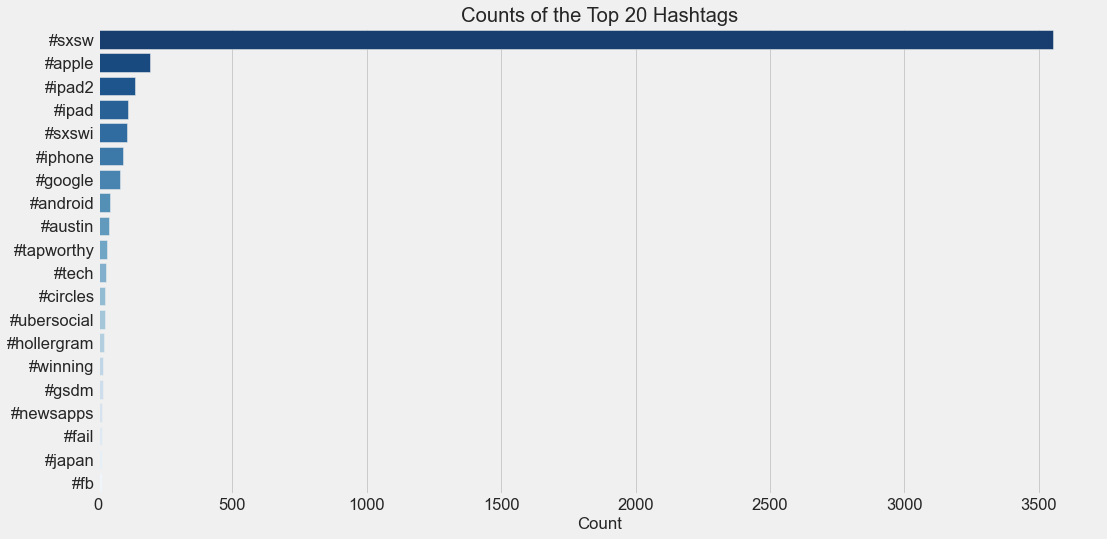

In [72]:
vz.hashtag_c(data_hts)

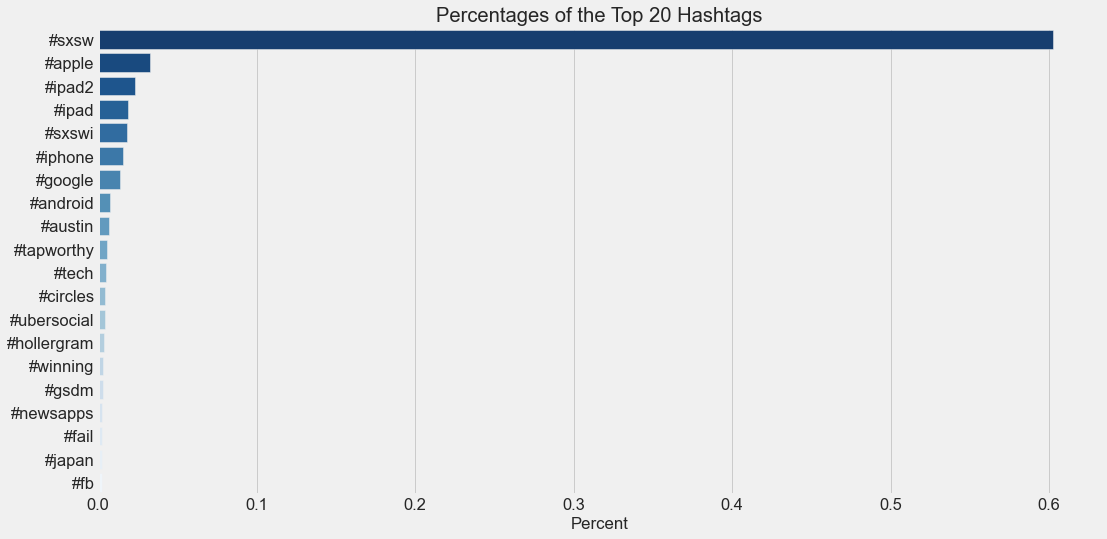

In [73]:
vz.hashtag_p(data_hts)

## Testing Tokenizations

### Strategy: (stopwords, string.punctuation)

In [74]:
# removing stopwords & punx
processed_data = list(map(fn.tweet_tokens, data))

# making vocab set
vocabulary = fn.vocabulary(processed_data)

#### Checking Out Our Vocab

In [75]:
# checking number of words
len(vocabulary)

6280

In [76]:
# first 100 words
for i, val in enumerate(itertools.islice(vocabulary, 100)):
    print(val)

app.û
rest
goog
bands
testing
seeing
twitter
p
bigger
planely
must
q
queue
4.0
brilliant
articles
wwsxsw
i-phone
constant
sloanxsw
find
stickers
stepped
cheapen
recognition
native
letting
stories
goûª
ht
average
searches
competitors.
overlay
playbook
sayin
drivers
begin
notionink
chair
summer
filter
laser
sxswû_
upbeat
cow
far-
expect
woah
google-sponsored
aclu/google
lustre
paradigms
rule
cut
b
3blks
tix
era
caused
autocorrected
principles
six
recommended
organizing
printed
logos
populous
i.e
bus
chain
breakfast
ftw
hhrs
rise_austin
lack
disneyland
warmth
amused
denotes
www.rana.co
geo-games
zazzlesxsw
futurecast
showing
balckberries
cluttering
glenda
left
achieve
thx
plug
begins
muting
14-day
iconbuffet
james
obsessed
designers/devs
taunt


In [77]:
# random 100 words
for i, val in enumerate(random.sample(vocabulary, 100)):
    print(val)

59
dj
stealing
attractive
rain
47
tveverywhere
ûïthe
pp
coupons
tablet-optimized
spazzmatics
localmind
aus
csr
impressions
wait
thirsty
nerd
coverage
att
continuous
positive
40
mood
conversion
cute
indigenous
-maybe
correcting
waze
evo
reacquainted
guessing
welivehere
movement
techiesunite
location
wireless
go2
wishing
noes
10mins
packrat
dow
hours
zimride
suns
kenny
schoolgirls
elevate
fam
sxsw-ers
super-fast
wired.com
responses
relationship
informed
subscription
media/marketing
gmail
wrapping
fly
augcomm
plunge
send
suggestions
nothing
birth
bucket
true
sold-out
livesteam
tmsxsw
thinks
ecko
aclus
television
v1
wannabe-hipsters
must.resist.mac.temptation
marissagoogle
tested
session
unloaded
hour
takeover
address
throughout
dennis
______
know
rpg
welcome
fave
viewed
dollars
timely
everbody
ideally


In [78]:
fn.string_checker(vocabulary, 'https')
fn.string_checker(vocabulary, 'madebymany')

string is in data
string is in data


### Strategy: (Regex: r'[a-zA-Z0-9]+')

In [79]:
# removing stopwords & punx
processed_data = list(map(fn.re_tokens, data))

vocabulary_re = fn.vocabulary(processed_data)

#### Checking Out Our Vocab

In [80]:
# number of words
len(vocabulary_re)

5861

In [81]:
# first 100 words
for i, val in enumerate(itertools.islice(vocabulary_re, 100)):
    print(val)

rest
goog
bands
testing
seeing
twitter
p
bigger
planely
must
q
jr
queue
brilliant
articles
wwsxsw
constant
sloanxsw
find
stickers
stepped
cheapen
recognition
native
letting
stories
ht
average
searches
overlay
playbook
sayin
drivers
begin
notionink
chair
summer
filter
laser
upbeat
cow
expect
woah
lustre
paradigms
bergstrom
rule
g03mzb
cut
b
3blks
tix
era
caused
autocorrected
principles
six
recommended
organizing
printed
logos
populous
bus
chain
breakfast
ftw
hhrs
lack
disneyland
warmth
amused
denotes
zazzlesxsw
futurecast
showing
balckberries
cluttering
glenda
left
achieve
thx
plug
begins
muting
iconbuffet
james
obsessed
taunt
trusted
powermat
fond
teeth
marissameyer
thats
taken
lookingforwardtothemusicfest
iphone
willpay
bjdproductions
fessing


In [82]:
# random 100 words
for i, val in enumerate(random.sample(vocabulary_re, 100)):
    print(val)

career
month
steampunk
buy
care
skiers
domain
cautiously
money
cabbies
tattoo
wp7
timing
birthday
playstation
done
shoulder
neumann
kyping
wild
presenting
crowdbeacon
castle
go
steals
engines
amazingly
pro
tme
r
fair
ahing
reviews
organize
canvas
undoubtedly
computer
interviewed
locations
sorta
religion
crowley
capped
1pm
54
cks
orly
learn
taught
talked
fire
memolane
asking
tweetie
betterthingstodo
join
untrue
saysshewithoutanipad
harris
unlocking
bpm
hotspot
stand
dictatorship
300
compact
doubly
cash
easily
surplus
envisioning
marissa
engaging
rad
innacurate
cameras
choreography
smudgy
whrrl
bank
charges
screen
answer
draining
curious
battlela
butts
tips
shameless
relationship
eye
hours
republic
beans
pretty
forgot
flow
detail
overheating
british


In [83]:
fn.string_checker(vocabulary_re, 'https')
fn.string_checker(vocabulary_re, 'madebymany')

string is in data
string is in data


## Testing Regularization Schemes

## Lemmatizing Data

In [84]:
lemmas = fn.lemmatize(processed_data)

In [85]:
len(lemmas)

3537

In [86]:
lemmas[:5]

['wesley83 3g iphone 3 hr tweeting rise austin dead need upgrade plugin station sxsw',
 'jessedee know fludapp awesome ipad iphone app likely appreciate design also giving free t sxsw',
 'swonderlin wait ipad 2 also sale sxsw',
 'sxsw hope year festival crashy year iphone app sxsw',
 'sxtxstate great stuff fri sxsw marissa mayer google tim reilly tech book conference amp matt mullenweg wordpress']

In [87]:
print(lemmas[0])
print(data[0])

wesley83 3g iphone 3 hr tweeting rise austin dead need upgrade plugin station sxsw
.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.


In [88]:
fn.string_checker(lemmas, 'https')
fn.string_checker(lemmas, 'madebymany')
fn.string_checker(vocabulary_re, 'rt')

string is not in data
string is not in data
string is in data


## Stemming Data

In [89]:
stems = fn.stemmatize(processed_data)

In [90]:
len(stems)

3537

In [91]:
stems[:5]

['wesley83 3g iphon 3 hr tweet rise austin dead need upgrad plugin station sxsw',
 'jessede know fludapp awesom ipad iphon app like appreci design also give free ts sxsw',
 'swonderlin wait ipad 2 also sale sxsw',
 'sxsw hope year festiv crashi year iphon app sxsw',
 'sxtxstate great stuff fri sxsw marissa mayer googl tim reilli tech book confer amp matt mullenweg wordpress']

In [92]:
print(stems[0])
print(data[0])

wesley83 3g iphon 3 hr tweet rise austin dead need upgrad plugin station sxsw
.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.


In [93]:
fn.string_checker(lemmas, 'https')
fn.string_checker(lemmas, 'madebymany')
fn.string_checker(vocabulary_re, 'rt')

string is not in data
string is not in data
string is in data


## Stem versus Lemm

In [94]:
for i in range(10):
    print(f'stem: {stems[i]}')
    print(f'lemm: {lemmas[i]} \n')

stem: wesley83 3g iphon 3 hr tweet rise austin dead need upgrad plugin station sxsw
lemm: wesley83 3g iphone 3 hr tweeting rise austin dead need upgrade plugin station sxsw 

stem: jessede know fludapp awesom ipad iphon app like appreci design also give free ts sxsw
lemm: jessedee know fludapp awesome ipad iphone app likely appreciate design also giving free t sxsw 

stem: swonderlin wait ipad 2 also sale sxsw
lemm: swonderlin wait ipad 2 also sale sxsw 

stem: sxsw hope year festiv crashi year iphon app sxsw
lemm: sxsw hope year festival crashy year iphone app sxsw 

stem: sxtxstate great stuff fri sxsw marissa mayer googl tim reilli tech book confer amp matt mullenweg wordpress
lemm: sxtxstate great stuff fri sxsw marissa mayer google tim reilly tech book conference amp matt mullenweg wordpress 

stem: sxsw start ctia around corner googleio hop skip jump good time android fan
lemm: sxsw starting ctia around corner googleio hop skip jump good time android fan 

stem: beauti smart simp

## Splitting Emotions

In [95]:
bin_positive = binary_data[binary_data['emotion']==1]
bin_negative = binary_data[binary_data['emotion']==0]

In [96]:
df_positive = bin_positive['tweet']
df_negative = bin_negative['tweet']

In [97]:
process_pos = list(map(fn.re_tokens, df_positive))
vocab_re_pos = fn.vocabulary(process_pos)
len(vocab_re_pos)

5027

In [98]:
process_neg = list(map(fn.re_tokens, df_negative))
vocab_re_neg = fn.vocabulary(process_neg)
len(vocab_re_neg)

2041